In [3]:
import os
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import r2_score

In [4]:
# 데이터셋 및 라벨 파일 경로 설정
data_folder = 'C:/Users/A/Desktop/224_Data'

train_data_folder = data_folder + '/Train'
val_data_folder = data_folder + '/Validation'
test_data_folder = data_folder + '/Test'

train_label_file = train_data_folder + '/train_labels.txt'
val_label_file = val_data_folder + '/val_labels.txt'
test_label_file = test_data_folder + '/test_labels.txt'

In [5]:

#calculate for normalize(min,max)
def load_and_combine_data(train_data_folder):
    file_paths = [os.path.join(train_data_folder, f) for f in os.listdir(train_data_folder) if f.endswith('9.txt')]
    all_data = []

    for file_path in file_paths:
        #Loading arrary data from each txt file
        data = np.loadtxt(file_path)
        all_data.append(data)

    #combine all data to one file
    combined_data = np.concatenate(all_data, axis=0)
    return combined_data

def calculate_statistics(data):
    min = np.min(data)
    max = np.max(data)
    return min, max

combined_data = load_and_combine_data(train_data_folder)
matrix_min, matrix_max = calculate_statistics(combined_data)


In [6]:

def scale_matrix(matrix):

    min_val = matrix.min()
    max_val = matrix.max()
    scaled_matrix = 2 * (matrix - min_val) / (max_val - min_val) - 1  # [0, 1] 범위로 스케일링 후 [-1, 1]로 변환
    scaled_matrix = np.round(scaled_matrix, 2)  # Numpy 배열로 변환 후 소수점 두 자리 반올림
    return scaled_matrix  # 결과를 numpy 배열로 반환


In [7]:
class CustomDataset(Dataset):
    def __init__(self, data_folder, label_file):
        self.data_folder = data_folder
        self.parameters = self.read_parameters(label_file) 
        self.data_numbers = list(self.parameters.keys())
        all_params = np.array(list(self.parameters.values()))
        self.label_min = np.min(all_params, axis=0)
        self.label_max = np.max(all_params, axis=0)

    def read_parameters(self, file_path):
        parameters = {}
        with open(file_path, 'r') as file:
            for index, line in enumerate(file):
                if index == 0:  # 첫 번째 줄(헤더) 건너뛰기
                    continue
                parts = line.strip().split(',')
                data_number = parts[0]
                params = np.array(parts[1:4], dtype=np.float32)  # 모든 파라미터를 포함하도록 수정
                parameters[data_number] = params
        return parameters

    def __len__(self):
        return len(self.data_numbers)

    def __getitem__(self, idx):
        data_number = self.data_numbers[idx]
        matrix_path = os.path.join(self.data_folder, f'{data_number}.txt')
        matrix = np.loadtxt(matrix_path)  # Load matrix from a txt file
        
        # 매트릭스 데이터 정규화 및 반올림
        matrix_normalized = scale_matrix(matrix)
        
        params = self.parameters[data_number]
        # 레이블 데이터 정규화 및 반올림
        params_normalized = (params - self.label_min) / (self.label_max - self.label_min)
        params_rounded = np.round(params_normalized, 2)  # 소수점 두 자리까지 반올림

        return torch.tensor(matrix_normalized).float().unsqueeze(0), torch.from_numpy(params_rounded).float()

In [8]:
# 훈련 및 테스트 데이터셋 생성
train_dataset = CustomDataset(data_folder=train_data_folder, label_file=train_label_file)
val_dataset = CustomDataset(data_folder=val_data_folder, label_file=val_label_file)
test_dataset = CustomDataset(data_folder=test_data_folder, label_file=test_label_file)

In [9]:
batch_size= 64

train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)

In [10]:
#convolution layer
def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)\
                     
def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

In [11]:
#bottleneck architecture
class Bottleneck(nn.Module):
    
    expansion = 4 # 블록 내에서 차원을 증가시키는 3번째 conv layer에서의 확장계수
    
    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d

        width = int(planes * (base_width / 64.)) * groups

        # Bottleneck Block의 구조
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation) # conv2에서 downsample
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x
        # 1x1 convolution layer
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        # 3x3 convolution layer
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        # 1x1 convolution layer
        out = self.conv3(out)
        out = self.bn3(out)
        # skip connection
        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

In [12]:
class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer
        # default values
        self.inplanes = 64 # input feature map
        self.dilation = 1
        # stride를 dilation으로 대체할지 선택
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        
        r"""
        - 처음 입력에 적용되는 self.conv1과 self.bn1, self.relu는 모든 ResNet에서 동일 
        - 3: 입력으로 RGB 이미지를 사용하기 때문에 convolution layer에 들어오는 input의 channel 수는 3 => matrix 사용할거라 1로 변경
        """
        self.conv1 = nn.Conv2d(1, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        r"""
        - 아래부터 block 형태와 갯수가 ResNet층마다 변화
        - self.layer1 ~ 4: 필터의 개수는 각 block들을 거치면서 증가(64->128->256->512)
        - self.avgpool: 모든 block을 거친 후에는 Adaptive AvgPool2d를 적용하여 (n, 512, 1, 1)의 텐서로
        - self.fc: 이후 fc layer를 연결
        """
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, # 여기서부터 downsampling적용
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        r"""
        convolution layer 생성 함수
        - block: block종류 지정
        - planes: feature map size (input shape)
        - blocks: layers[0]와 같이, 해당 블록이 몇개 생성돼야하는지, 블록의 갯수 (layer 반복해서 쌓는 개수)
        - stride와 dilate은 고정
        """
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        
        # the number of filters is doubled: self.inplanes와 planes 사이즈를 맞춰주기 위한 projection shortcut
        # the feature map size is halved: stride=2로 downsampling
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        # 블록 내 시작 layer, downsampling 필요
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion # inplanes 업데이트
        # 동일 블록 반복
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def _forward_impl(self, x):
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x):
        return self._forward_impl(x)

In [13]:
def Resnet(resnet50, Bottleneck, layers, pretrained, progress, **kwargs):
    r"""
    - pretrained: pretrained된 모델 가중치를 불러오기 (saved by caffe)
    - arch: ResNet모델 이름
    - block: 어떤 block 형태 사용할지 ("Basic or Bottleneck")
    - layers: 해당 block이 몇번 사용되는지를 list형태로 넘겨주는 부분
    """
    model = ResNet(Bottleneck, layers, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[resnet50], progress=progress)
        model.load_state_dict(state_dict)
    return model

In [14]:
#Resnet50
def resnet50(pretrained=False, progress=True, **kwargs):
    return Resnet('resnet50', Bottleneck, [3, 4, 6, 3], pretrained, progress, **kwargs)

In [15]:
label_size = 3
model_instance = resnet50(pretrained=False)
model_instance.fc = nn.Linear(model_instance.fc.in_features, label_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model_instance.parameters(), lr=0.0015)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
device = torch.device("cuda:0")
model_instance.to(device)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [18]:
# 모델 가중치 로드
model_weights = torch.load('C:/Users/A/Desktop/resnet50_best/Mar07_10-43-45_유효숫자_2자리/best_model.pth', map_location=device)

# 가중치를 모델에 적용
model_instance.load_state_dict(model_weights)

# 모델을 평가 모드로 전환 (학습이 아닌, 평가나 추론을 위한 준비)
model_instance.eval()


ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [19]:
import matplotlib.pyplot as plt

model_instance.eval()  # 평가 모드로 설정
test_loss = 0.0
total_samples = 0

# 실제 값과 예측 값 저장을 위한 리스트 초기화
actuals = []
predictions = []

with torch.no_grad():  # 기울기 계산 비활성화
    for data in test_loader:
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model_instance(inputs)
        
        # MSE 손실 계산
        loss = criterion(outputs, labels)
        test_loss += loss.item() * inputs.size(0)  # 배치에 대한 손실을 누적하고, 샘플 수로 가중치를 줌
        total_samples += inputs.size(0)
        
        # 실제 값과 예측 값을 리스트에 저장
        actuals.extend(labels.cpu().numpy())
        predictions.extend(outputs.cpu().numpy())

# 전체 테스트 세트에 대한 평균 MSE 계산
avg_test_mse = test_loss / total_samples
print(f'Test MSE: {avg_test_mse}')

# 전체 테스트 세트에 대한 R^2 스코어 계산
r2_scores = [r2_score(np.array(actuals)[:, i], np.array(predictions)[:, i]) for i in range(np.array(actuals).shape[1])]
print(f"Test R2 scores: {r2_scores}")
print(f"  Mean of R2 score: {np.mean(r2_scores)}")


Test MSE: 0.0078583888870118
Test R2 scores: [0.777857214495379, 0.981799242688402, 0.9865581726434443]
  Mean of R2 score: 0.9154048766090751


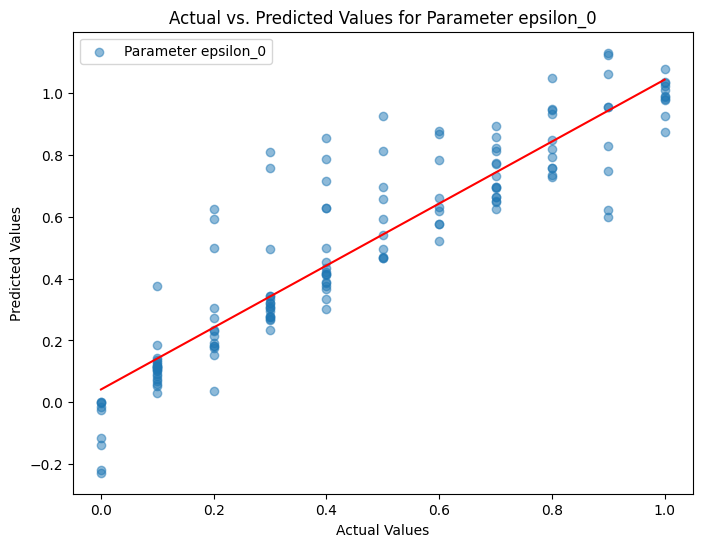

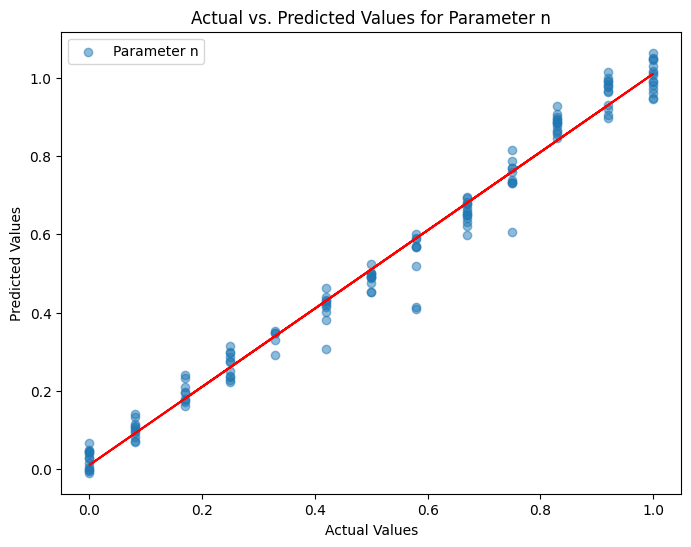

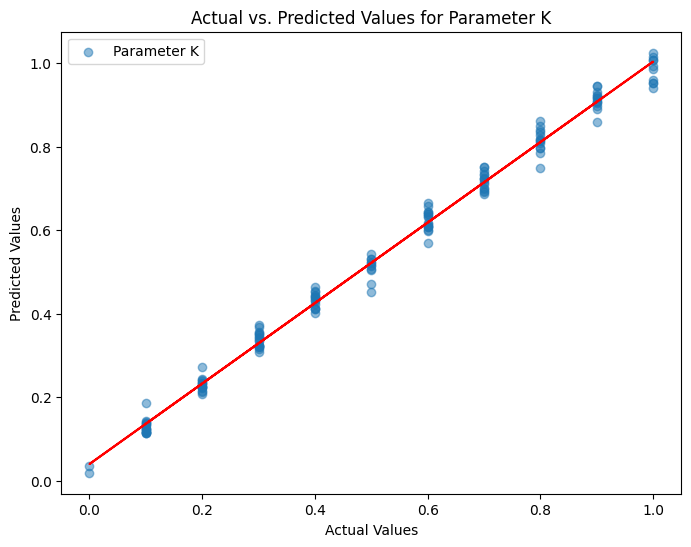

In [20]:
# 각 차원별로 회귀 그래프 그리기
num_dimensions = actuals[0].shape[0]  # 라벨 데이터의 차원 수 (여기서는 3)
for i in range(num_dimensions):

    actuals_i = [x[i] for x in actuals]  # i번째 차원의 실제 값
    predictions_i = [x[i] for x in predictions]  # i번째 차원의 예측 값
    
    plt.figure(figsize=(8, 6))
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')

    if i==0:
        plt.scatter(actuals_i, predictions_i, alpha=0.5, label=f'Parameter epsilon_0')
        plt.title(f'Actual vs. Predicted Values for Parameter epsilon_0')

    if i==1:
        plt.scatter(actuals_i, predictions_i, alpha=0.5, label=f'Parameter n')
        plt.title(f'Actual vs. Predicted Values for Parameter n')

    if i==2:
        plt.scatter(actuals_i, predictions_i, alpha=0.5, label=f'Parameter K')
        plt.title(f'Actual vs. Predicted Values for Parameter K')
        
    
    # 회귀선 그리기
    z = np.polyfit(actuals_i, predictions_i, 1)  # 1차원 다항식 계수 찾기
    p = np.poly1d(z)  # 1차원 다항식 생성
    plt.plot(actuals_i, p(actuals_i), color='red')  # 회귀선 그리기
    
    plt.legend()
    plt.show()


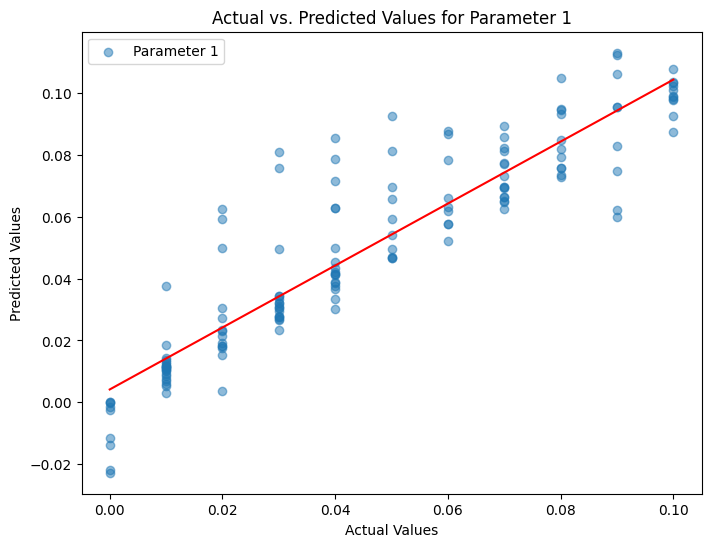

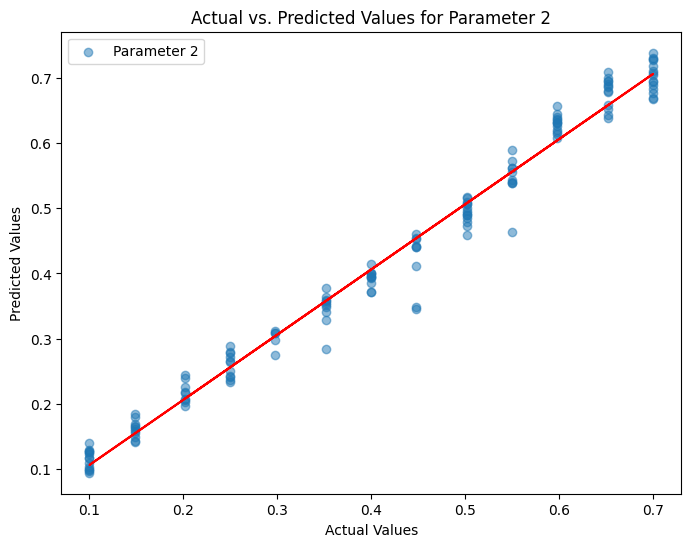

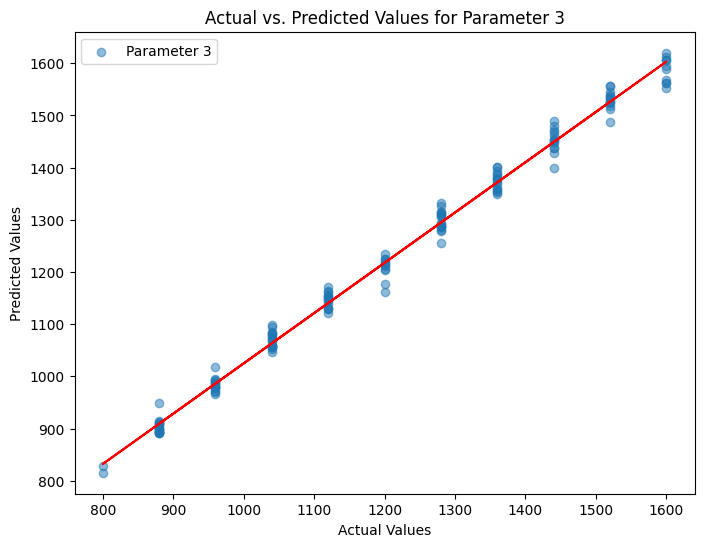

In [21]:
def denormalize(params, min_vals, max_vals):
    """노멀라이즈된 파라미터 값을 원래의 스케일로 되돌립니다."""
    return params * (max_vals - min_vals) + min_vals

# 각 차원별 최소, 최대값 설정
label_mins = [0, 0.1, 800]
label_maxs = [0.1,0.7, 1600]

num_dimensions = actuals[0].shape[0]  # 라벨 데이터의 차원 수 (여기서는 3)

for i in range(num_dimensions):
    actuals_i = np.array([x[i] for x in actuals])  # i번째 차원의 실제 값
    predictions_i = np.array([x[i] for x in predictions])  # i번째 차원의 예측 값

    # 노멀라이즈된 값을 원래의 스케일로 되돌림
    actuals_i_denorm = denormalize(actuals_i, label_mins[i], label_maxs[i])
    predictions_i_denorm = denormalize(predictions_i, label_mins[i], label_maxs[i])
    
    plt.figure(figsize=(8, 6))
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.scatter(actuals_i_denorm, predictions_i_denorm, alpha=0.5, label=f'Parameter {i+1}')
    plt.title(f'Actual vs. Predicted Values for Parameter {i+1}')

    # 회귀선 그리기
    z = np.polyfit(actuals_i_denorm, predictions_i_denorm, 1)  # 1차원 다항식 계수 찾기
    p = np.poly1d(z)  # 1차원 다항식 생성
    plt.plot(actuals_i_denorm, p(actuals_i_denorm), color='red')  # 회귀선 그리기
    
    plt.legend()
    plt.show()
